# Trafic Signs Recognition

### Check if tensorflow will use GPU

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Import required packages

In [2]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import backend as K
# K.tensorflow_backend._get_available_gpus()
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

root_dir = 'GTSRB\\Final_Training\\Images\\'

print("finish step 1")

finish step 1


## Understand dataset

In [3]:
all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
print("Number singns in training set: {}".format(len(all_img_paths)))
number_of_classes = glob.glob(os.path.join(root_dir, '*/00000_00000.ppm'))
print("Number of classes: {}".format(len(number_of_classes)))

Number singns in training set: 39209
Number of classes: 43


Example sign from each class


TypeError: imread() got an unexpected keyword argument 'as_gray'

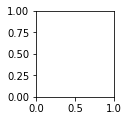

In [4]:
from matplotlib.pyplot import figure, imshow, axis, tight_layout, show
from matplotlib.image import imread

def showImagesInGrid(list_of_files):
    fig = figure(figsize=(13, 13))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files/7+1,8,i+1)
        image = imread(list_of_files[i], as_gray=True)
        imshow(image)
#         axis('off')

print("Example sign from each class")
image_from_each_class_paths = glob.glob(os.path.join(root_dir, '*/00002_00010.ppm'))
showImagesInGrid(image_from_each_class_paths)

Sample class trainig examples

In [ ]:
examples_from_class = 12

examples_from_one_class_path = '*0{}/*_00029.ppm'.format(examples_from_class)
print("Example signs from one class")
image_from_one_class_paths = glob.glob(os.path.join(root_dir, examples_from_one_class_path))
showImagesInGrid(image_from_one_class_paths)

Each sign real life sign in dataset has already generated 30 variation of it 

In [ ]:
examples_from_class = 12
sign_no_varations = 1

examples_from_one_class_path = '*0{}/*0{}_*.ppm'.format(examples_from_class, sign_no_varations)
print("Example signs from one class")
image_from_one_class_paths = glob.glob(os.path.join(root_dir, examples_from_one_class_path))
showImagesInGrid(image_from_one_class_paths)

In [ ]:
def preprocess_img(img):

    img = preprocess_img_without_rollaxis(img)

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def preprocess_img_without_rollaxis(img):
    # Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

#     central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))    
    return img

def get_class(img_path):
    return int(img_path.split('\\')[-2])
print("finish step 2")

Test image preprocessing functions below

In [ ]:
examples_from_one_class_path = '00001/00001_00029.ppm'
image_from_one_class_paths = os.path.join(root_dir, examples_from_one_class_path)

def showImagesInGridImages(list_of_files):
    fig = figure(figsize=(13, 13))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files/7+1,2,i+1)
#         image = imread(list_of_files[i])
        imshow(list_of_files[i])

images = []

images.append(io.imread(image_from_one_class_paths, as_gray=True))
img = io.imread(image_from_one_class_paths, as_gray=True)
images.append(preprocess_img_without_rollaxis(img))

showImagesInGridImages(images)


## Preprocess all training images into a numpy array

In [ ]:
try:
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path, as_gray=True))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%3000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

    print("finish step 3")
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")

# Define Keras model

In [ ]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(1, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
# let's train the model using SGD + momentum.
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

print("finish step 4")

# Start Training

In [ ]:
batch_size = 32
nb_epoch = 30

model.fit(X, Y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True
#           ,callbacks=[LearningRateScheduler(lr_schedule),
#                     ModelCheckpoint('model.h5',save_best_only=True)]
            )

# Load Test data

In [ ]:
import pandas as pd
test = pd.read_csv('GT-final_test.csv',sep=';')

X_test = []
y_test = []
i = 0
print("list lenght {})".format(len(list(test['Filename']))))
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('GTSRB\\Final_Test\\Images\\',file_name)
    X_test.append(preprocess_img(io.imread(img_path, as_gray=True)))
    y_test.append(class_id)
    if len(X_test)%1000 == 0: print("Processed {}/{}".format(len(X_test), len(y_test)))
    
    
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_pred = model.predict_classes(X_test)
print(y_pred)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

In [ ]:
bad_preciction = 0
show_every_each = 10
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        bad_preciction += 1
        if bad_preciction%show_every_each == 0:
            print("No. {}: predicted: {} real: {}".format(bad_preciction, y_pred[i], y_test[i]))
            file_name = list(test['Filename'])[i]
            img_path = os.path.join('GTSRB\\Final_Test\\Images\\',file_name)
            imshow(preprocess_img_without_rollaxis(io.imread(img_path, as_gray=True)))
            show()
            img_path_for_sample_from_predicted_class = glob.glob(os.path.join(root_dir, '*00{}/00001_00010.ppm'.format(y_pred[i])))
            imshow(preprocess_img_without_rollaxis(io.imread(img_path_for_sample_from_predicted_class[0], as_gray=True)))
            show()
            samples_to_show -= 1

print("Wrong prediction for {} out of {} test samples".format(bad_preciction, len(y_test)))
        
        

In [ ]:
model.summary()

In [ ]:
model.count_params()